# Network 2

The size of the data loaded in this notebook is 100.000 
(since 1/4 of the data is kept for validation and 1/4 for predictions, the network is trained on 50.000 samples)

Using the python files on my computer, I trained the network on more data (500.000) 

This explains the divergence in results.

I chose to present this notebook on a shrinked data set because generating the data takes a lot of time and saving them in pickle files also. Moreover, the results are also very interesting on this amount of data :-)
(I also tried to load a trained network, but for no reason this does not seem to work here :-/ )

In [3]:
#import matplotlib
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#import glob
import os
import sys
import pickle
import time

#from IPython.display import clear_output
#from skimage.io import imread
#from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn.parameter import Parameter

from sklearn.preprocessing import StandardScaler

path_to_utils = os.path.join('.', 'python_functions')
path_to_utils = os.path.abspath(path_to_utils)
if path_to_utils not in sys.path:
    sys.path.insert(0, path_to_utils)

import mf_utils as util
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy import stats

from sklearn.metrics import mean_absolute_error

### Basic parameters

In [12]:
#%% Basic parameters

num_atoms = 782
num_fasc = 2
num_params = 6 #nombre de paramètres à estimer: ['nu1', 'r1 ', 'f1 ', 'nu2', 'r2 ', 'f2 ']


params = {
    #Training parameters
    "num_samples": 100000,
     "batch_size": 500,  
     "num_epochs": 50,
     
     #NW1 parameters
     #"num_w_out": hp.choice("num_w_out", [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30] ),
     "num_w_out": 12,
     "num_w_l1": 500,
     "num_w_l2": 50,
     
     #NW2
     "num_f_l1": 200,
     "num_f_l2": 100,
     
     #other
     "learning_rate": 0.001,
     #"learning_rate": hp.uniform("learningrate", 0.0005, 0.01),
     "dropout": 0.3
     #"dropout": hp.uniform("dropout", 0, 0.4)
}

num_samples = params["num_samples"]
num_div = int(num_samples/4)

### Get the data

In [13]:
# Data

filename = 'dataNW2_w_store'
w_store = pickle.load(open(filename, 'rb'))

filename = 'dataNW2_targets'
target_params = pickle.load(open(filename, 'rb'))

print(w_store.shape)
print(target_params.shape)

torch.Size([100000, 1564])
torch.Size([100000, 6])


To have an idea of the sparsity of the w vectors, let's print one :-)

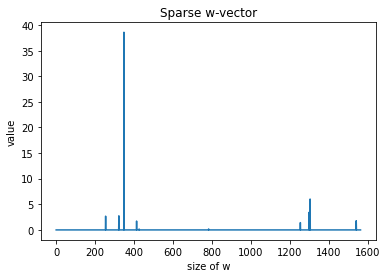

In [28]:
w_print = w_store[0,:]
n_w = len(w_print)

plt.figure()
plt.plot(range(n_w), w_print)
plt.title('Sparse w-vector')
plt.xlabel('size of w'), plt.ylabel('value')
plt.show()

Some more manipulation of the data

In [14]:
w_store1 = w_store[0:num_div*2, :]
w_store2 = w_store[num_div*2:num_div*4, :]
target_params1 = target_params[0:num_div*2, :]
target_params2 = target_params[num_div*2:num_div*4, :]

w_reshape = np.zeros((num_samples, num_atoms, num_fasc))

w_reshape[0:num_div*2, :,0] = w_store1[:, 0:num_atoms]
w_reshape[0:num_div*2,:,1] = w_store1[:, num_atoms: 2*num_atoms]
w_reshape[num_div*2:num_samples,:,0] = w_store2[:, 0:num_atoms]
w_reshape[num_div*2:num_samples,:,1] = w_store2[:, num_atoms: 2*num_atoms]

print(w_reshape.shape)

# divide data in train, test and validation
x_train = w_reshape[0:2*num_div, :, :]
x_test = w_reshape[2*num_div : 3*num_div , :, :]
x_valid = w_reshape[3*num_div : 4*num_div, :, :]

print('x_train size', x_train.shape)
print('x_test size', x_test.shape)
print('x_valid size', x_valid.shape)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
x_valid = torch.from_numpy(x_valid)

# quelques modifs pour le modele neuronal
x_train = x_train.float()
x_test = x_test.float()
x_valid = x_valid.float()

(100000, 782, 2)
x_train size (50000, 782, 2)
x_test size (25000, 782, 2)
x_valid size (25000, 782, 2)


### Load the targets

In [15]:
print("--- Taking microstructural properties of fascicles ---")

#Scaling: scaler: (num_samples, num_features)

scaler_train = StandardScaler()
target_params1 = scaler_train.fit_transform(target_params1)
target_params1 = torch.from_numpy(target_params1)

scaler_valid = StandardScaler()
target_params2 = scaler_valid.fit_transform(target_params2)
target_params2 = torch.from_numpy(target_params2)

## Dividing in train test and valid

target_train = target_params1[:, :]
target_test = target_params2[0:num_div, :]
target_valid = target_params2[num_div:2*num_div, :]

target_train = target_train.float()
target_test = target_test.float()
target_valid = target_valid.float()

print(target_train[0, :])

print('target_train size', target_train.shape)
print('target_test size', target_test.shape)
print('target_valid size', target_valid.shape)

--- Taking microstructural properties of fascicles ---
tensor([ 1.5187, -0.1482, -1.2063, -1.5187,  0.5662,  0.3006])
target_train size torch.Size([50000, 6])
target_test size torch.Size([25000, 6])
target_valid size torch.Size([25000, 6])


### Defining the networks

In [16]:
# Network 1

class Net_w(nn.Module):

    def __init__(self, num_in, num_h1, num_h2, num_out, drop_prob):
        super(Net_w, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h1, num_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_h1), 0))

        # hidden layer
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h2, num_h1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_h2), 0))
        
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_out, num_h2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_out), 0))
        
        self.activation = torch.nn.ReLU()
        
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):

        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)

        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_3, self.b_3)

        return x


# Network 2
class Net_f(nn.Module):

    def __init__(self, num_in, num_h1, num_h2, num_out, drop_prob):
        super(Net_f, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h1, num_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_h1), 0))

        # hidden layer
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h2, num_h1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_h2), 0))
        
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_out, num_h2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_out), 0))
        
        self.activation = torch.nn.ReLU()
        
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):

        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.dropout(x)
        x = F.linear(x, self.W_3, self.b_3)

        return x

# Network 3
class Net_tot(nn.Module):

    def __init__(self, numw_in, numw_l1, numw_l2, numw_out, numf_in, numf_l1, numf_l2, numf_out, drop):
        super(Net_tot, self).__init__()  
        self.netw = Net_w(numw_in, numw_l1, numw_l2, numw_out, drop_prob=drop)
        self.netf = Net_f(numf_in, numf_l1, numf_l2, numf_out, drop_prob=drop)

    def forward(self, w1, w2):
        x1 = self.netw(w1)
        x2 = self.netw(w2)
        
        x = torch.cat((x1, x2), axis=1)

        x = self.netf(x)

        return x

### Making the training loop

In [17]:
def train_network(params: dict):
    # Building training loop
    num_w_out = params["num_w_out"] #??
    num_w_l1 = params["num_w_l1"]
    num_w_l2 = params["num_w_l2"]
    num_w_in = num_atoms
    num_f_out = num_params #nombre de paramètres à estimer
    num_f_l1 = params["num_f_l1"]
    num_f_l2 = params["num_f_l2"]
    num_f_in = num_w_out*num_fasc #ici 10*2
    drop = params["dropout"]
    
    net_tot = Net_tot(num_w_in, num_w_l1, num_w_l2, num_w_out, num_f_in, num_f_l1, num_f_l2, num_f_out, drop)
    
    print(net_tot)
    
    # Optimizer and Criterion
    
    optimizer = optim.Adam(net_tot.parameters(), lr=params["learning_rate"], weight_decay=0.0000001)
    lossf = nn.MSELoss()
    
    
    print('----------------------- Training --------------------------')
    
    start = time.time()
    
    # setting hyperparameters and gettings epoch sizes
    batch_size = params["batch_size"] #100 
    num_epochs = params["num_epochs"] #200
    #print(x_train.shape)
    
    #shapes = x_train.shape
    num_samples_train = int(num_samples/2)
    num_batches_train = num_samples_train // batch_size #??
    num_samples_valid = int(num_samples/4)
    num_batches_valid = num_samples_valid // batch_size
    
    # setting up lists for handling loss/accuracy
    train_acc = np.zeros((num_epochs, num_params))
    valid_acc = np.zeros((num_epochs, num_params))
    
    meanTrainError, meanValError  = [], []

    cur_loss = 0
    losses = []
    
    # lambda function
    get_slice = lambda i, size: range(i * size, (i + 1) * size)
    
    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss = 0
        net_tot.train()
        
        for i in range(num_batches_train):
            
            optimizer.zero_grad()
            slce = get_slice(i, batch_size)
    
            output = net_tot(x_train[slce, :, 0], x_train[slce, :, 1])
            
            # compute gradients given loss
            target_batch = target_train[slce]
            batch_loss = lossf(output, target_batch)
            batch_loss.backward()
            optimizer.step()
            
            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)
        #print(cur_loss / batch_size)
    
        net_tot.eval()
        
        ### Evaluate training
        train_preds = [[], [], [], [], [], []]
        train_targs = [[], [], [], [], [], []]
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            preds = net_tot(x_train[slce, :, 0], x_train[slce, :, 1])
            
            for j in range(num_params):
                train_targs[j] += list(target_train[slce, j].numpy())
                train_preds[j] += list(preds.data[:,j].numpy())
            
        ### Evaluate validation
        val_preds = [[], [], [], [], [], []]
        val_targs = [[], [], [], [], [], []]
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            preds = net_tot(x_valid[slce, :, 0], x_valid[slce, :, 1])
            
            for j in range(num_params):
                val_targs[j] += list(target_valid[slce, j].numpy())
                val_preds[j] += list(preds.data[:,j].numpy())
                
        # Save evaluation and training
        train_acc_cur = np.zeros(num_params)
        valid_acc_cur = np.zeros(num_params)
        for j in range(num_params):
            train_acc_cur[j] = mean_absolute_error(train_targs[j], train_preds[j])
            valid_acc_cur[j] = mean_absolute_error(val_targs[j], val_preds[j])
            train_acc[epoch, j] = train_acc_cur[j]
            valid_acc[epoch, j] = valid_acc_cur[j]
        
        #print(train_acc)
        #print(train_acc)
        meanTrainError.append(np.mean(train_acc[epoch,:]))
        meanValError.append(np.mean(valid_acc[epoch, :]))
        
        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f, " %(
                    epoch+1, losses[-1], meanTrainError[-1], meanValError[-1]))
        
    to_min = sum(valid_acc_cur)
    
    end = time.time()
    t = end-start
      
    return {"loss": to_min, 
            "model": net_tot, 
            "params": params, 
            "status": STATUS_OK,
            "train_acc": train_acc,
            "valid_acc": valid_acc,
            "meanTrainError": meanTrainError,
            "meanValError": meanValError,
            "time": t
            }

### Training the Network

In [19]:
trial = train_network(params)  

print("training time:", trial['time'], "[sec]")

Net_tot(
  (netw): Net_w(
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (netf): Net_f(
    (activation): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
)
----------------------- Training --------------------------
100 50
Epoch  1 : Train Loss 0.295721 , Train acc 0.864983, Valid acc 0.864089, 
Epoch 11 : Train Loss 0.106735 , Train acc 0.514848, Valid acc 0.518500, 
Epoch 21 : Train Loss 0.080795 , Train acc 0.426925, Valid acc 0.436817, 
Epoch 31 : Train Loss 0.066913 , Train acc 0.377001, Valid acc 0.395943, 
Epoch 41 : Train Loss 0.061023 , Train acc 0.353597, Valid acc 0.382434, 
training time: 395.09237790107727 [sec]


### Graphs for training: learning curve

Here I first print the errors for the 6 properties individually 

then I print the mean errors, which represents my learning curve

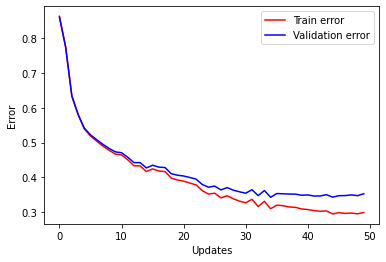

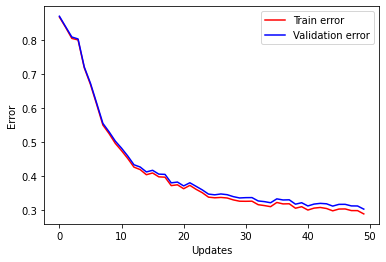

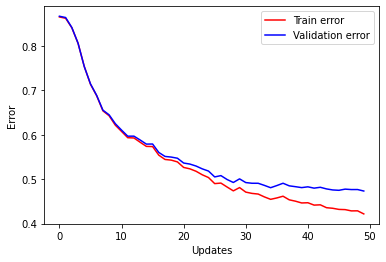

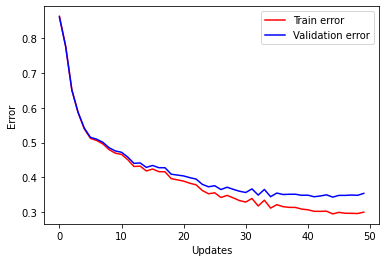

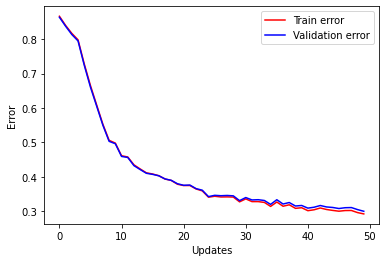

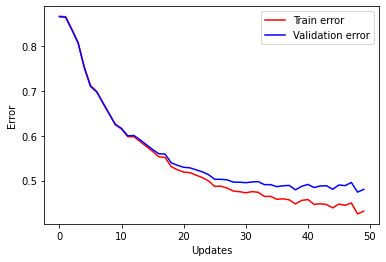

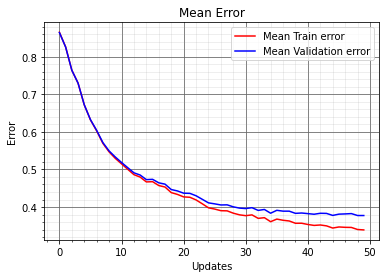

In [30]:
train_acc = trial['train_acc']
valid_acc = trial['valid_acc']
epoch = np.arange(params['num_epochs'])

mean_train_error = trial['meanTrainError']

for j in range(num_params):    
    plt.figure()
    plt.plot(epoch, train_acc[:, j], 'r', epoch, valid_acc[:, j], 'b')
    plt.legend(['Train error','Validation error'])
    plt.xlabel('Updates'), plt.ylabel('Error')
    plt.show()
    
meanTrainError = trial['meanTrainError']
meanValError = trial['meanValError']

# Mean Error
plt.figure()
plt.plot(epoch, meanTrainError, 'r', epoch, meanValError, 'b')
plt.title('Mean Error')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(['Mean Train error','Mean Validation error'])
plt.xlabel('Updates'), plt.ylabel('Error')
plt.show()

### Predictions

----------------------- Prediction --------------------------
torch.Size([25000, 782, 2])
[6.2625617e-01 3.6848273e-06 6.7424816e-01 6.2511200e-01 3.7108432e-06
 6.7375219e-01]


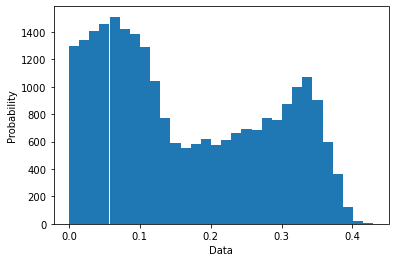

In [29]:
print('----------------------- Prediction --------------------------')

net_tot = trial['model']

print(x_test.shape)
output = net_tot(x_test[:,:,0], x_test[:,:,1])
output = output.detach().numpy()

output = scaler_valid.inverse_transform(output)
target_test = scaler_valid.inverse_transform(target_test)

print(target_test[0, :])

error = output - target_test

abserror = abs(error)

plt.figure()
plt.hist(abserror[:,0], density=False, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

### Confidence intervals

In [26]:
conf_int = np.zeros(num_params)

for j in range(num_params):
    #plt.plot(error[:,j])
    #plt.show()
    data = error[:,j]
    
    mean = np.mean(data)
    sigma = np.std(data)
    
    confint = stats.norm.interval(0.95, loc=mean, 
        scale=sigma)
    
    print(confint)

(-0.43501631345670777, 0.17580676999013978)
(-3.053899190794081e-06, 3.049149757058896e-06)
(-0.4114389711320571, 0.10307824549080646)
(-0.42532980375371693, 0.18481582336507557)
(-2.985355274474779e-06, 3.0474244935725723e-06)
(-0.4107070526312922, 0.092682894153509)


### Optimization of parameters

For this part the parameter dictionnary needs to be changed and it takes a lot of time to run
The analysis was done on
- dropout
- number of outputs of split layer
- learning rate

In [ ]:
trials = Trials()
best = fmin(train_network, params, algo=tpe.suggest, max_evals=1, trials=trials)

In [ ]:
n = len(trials.results)
tomin = np.zeros(n)
to_opti = np.zeros(n)
for i in range(n):
    tomin[i]= trials.results[i]['loss']
    to_opti[i] = trials.results[i]['params']['num_w_out']
    
print(tomin)
print(to_opti)

#plt.figure()
#plt.plot(dropout, tomin, 'b')
#plt.title('Optimisation of dropout (lr=0.001)')
#plt.grid(b=True, which='major', color='#666666', linestyle='-')
#plt.minorticks_on()
#plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.xlabel('dropout'), plt.ylabel('Sum of errors')
#plt.show()

plt.figure()
plt.scatter(to_opti, tomin)
plt.title('Influence of number of output of split network (dropout=0.05, lr=0.001)')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('nun_w_out'), plt.ylabel('Sum of errors')
plt.show()